## Вариант 5. Контроль градиентов через глубину

**Цель:** Изучение поведения градиентов в глубокой сети.

- Разработайте сеть с **не менее 6 слоев**, которая выводит тензор `(batch, 64, 8, 8)`.
- **Условие:** Слои должны чередоваться между `Conv2d` и `ReLU`, при этом **градиенты первого слоя должны быть меньше градиентов последнего** после одной итерации `backward()` на случайных данных.
- **Эксперимент:** Визуализируйте градиенты по слоям и объясните, почему градиенты убывают или растут.

In [8]:
import torch
from torch import nn

In [9]:

class GradConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x) # (8x8x8)
        x = self.relu(x)
        
        x = self.conv2(x) # (16x8x8)
        x = self.relu(x)

        x = self.conv3(x) # (32x8x8)
        x = self.relu(x)

        x = self.conv4(x) # (64x8x8)
        x = self.relu(x)

        x = self.conv5(x) # (128x8x8)
        x = self.relu(x)

        x = self.conv6(x) # (64x8x8)
        x = self.relu(x)
        return x

model = GradConvNet()

test_tensor = torch.randn(1, 3, 8, 8, requires_grad=True)

model(test_tensor).size()

torch.Size([1, 64, 8, 8])

In [10]:
from torch.optim import Adam

x = torch.randn(1, 3, 8, 8, requires_grad=True)
y_true = torch.randn(1, 64, 8, 8, requires_grad=True)
y_pred = model(x)

criterion = nn.CrossEntropyLoss()
loss = criterion(y_pred, y_true)

print("Loss:", loss.item())

loss.backward()


Loss: -5.67793083190918


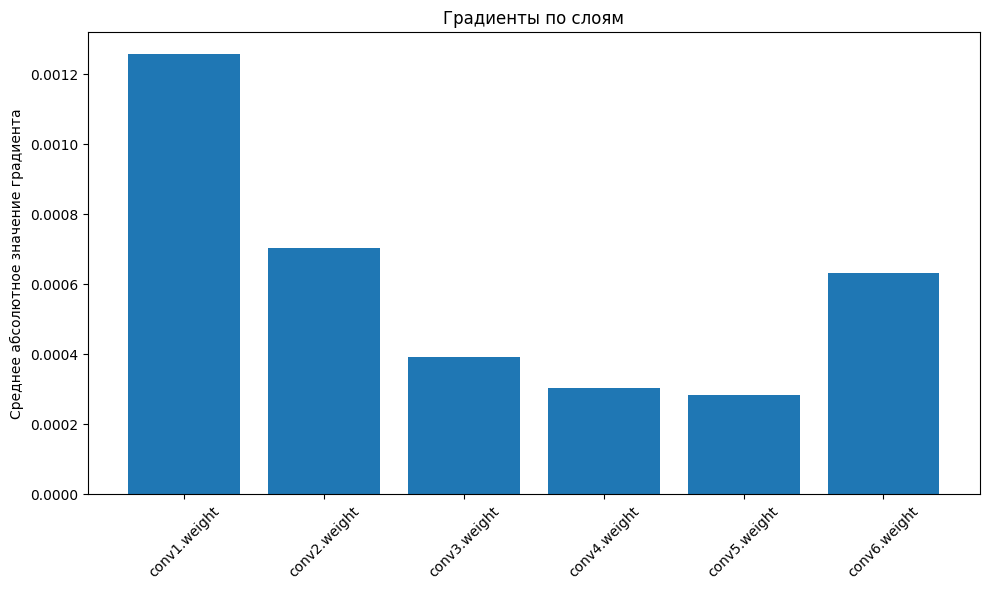

In [ ]:
import matplotlib.pyplot as plt

def plot_layer_gradients(model):
    grad_means = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            grad_means.append(param.grad.abs().mean().item())
            layer_names.append(name)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(grad_means)), grad_means)
    plt.xticks(range(len(grad_means)), layer_names, rotation=45)
    plt.ylabel('Среднее абсолютное значение градиента')
    plt.title('Градиенты по слоям')
    plt.tight_layout()
    plt.show()

plot_layer_gradients(model)

### Видно, что градиенты уменьшаются при росте output_size каждого из слоев, и увеличиваются на слое 6, на котором output_size меньше, чем input_size. Скорее всего, это связано с вычислением частных производных при back propagation, поскольку градиент при увеличении выходного размера размазывается по нескольким пикселям. Также, вероятно, повлияла функция ReLu в качестве функции активации, поскольку она имеет производную, равную единице в правой полуплоскости, и равную нулю - в левой, и если какой-либо из выходных сигналов слоя имеет отрицательное значение, то он обращается в ноль, что уменьшает среднюю частную производную и влияет на back propagation.